In [1]:
using PauliPropagation
using Plots

### X drive to ZZ target (Test of the DQA)

In [67]:
#define hyperparams
nq = 5
del_t = 1.0
P= 20
tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
topology = bricklayertopology(nq; periodic=false)
circuit = tfitrottercircuit(nq, P; topology=topology, start_with_ZZ=false) # 1st order trotter
#println(circuit)
nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
total = P * (nq + nbonds)
params  = Vector{Float64}(undef, total)

hbar = 1.0
G = -1.0
J = 1.0

idx = 1
for m in 1:P # layers of trotterized circuit
    #s_m = m / P
    s_m = (m - 0.5) / P #evaluate at middle of trotter slice

    gamma_m = s_m * del_t /hbar
    #println(gamma_m)   # paper Eq. (12)
    beta_m = (1-s_m) * del_t / hbar # paper Eq. (13a) - 1st order trotter
    #println(beta_m)
    theta_X = 2*beta_m * G 
    ##println(theta_X)              # angle for e^{-i theta_X X_j/2} - PauliRotation implementation in PP
    theta_ZZ = 2*gamma_m * J              # angle for e^{-i theta_ZZ Z_j Z_{j+1}/2}
    ##println(theta_ZZ)
    @inbounds fill!(view(params, idx:idx+nq-1), theta_X);             idx += nq # set X angles,then shift the index
    #println(params)
    @inbounds fill!(view(params, idx:idx+nbonds-1), theta_ZZ);       idx += nbonds
    #println(params)
end
H_ZZ = PauliSum(nq)
for pair in topology
    add!(H_ZZ, [:Z, :Z], collect(pair), J)
end

max_weight = 10
min_abs_coeff = 1e-7
propagated = propagate(circuit, H_ZZ, params)#; max_weight, min_abs_coeff)
println(overlapwithplus(propagated))


-3.9560409190658277


In [60]:
println(params)

[-1.95, -1.95, -1.95, -1.95, -1.95, 0.05, 0.05, 0.05, 0.05, -1.85, -1.85, -1.85, -1.85, -1.85, 0.15, 0.15, 0.15, 0.15, -1.75, -1.75, -1.75, -1.75, -1.75, 0.25, 0.25, 0.25, 0.25, -1.65, -1.65, -1.65, -1.65, -1.65, 0.35, 0.35, 0.35, 0.35, -1.55, -1.55, -1.55, -1.55, -1.55, 0.45, 0.45, 0.45, 0.45, -1.45, -1.45, -1.45, -1.45, -1.45, 0.55, 0.55, 0.55, 0.55, -1.35, -1.35, -1.35, -1.35, -1.35, 0.65, 0.65, 0.65, 0.65, -1.25, -1.25, -1.25, -1.25, -1.25, 0.75, 0.75, 0.75, 0.75, -1.15, -1.15, -1.15, -1.15, -1.15, 0.85, 0.85, 0.85, 0.85, -1.05, -1.05, -1.05, -1.05, -1.05, 0.95, 0.95, 0.95, 0.95, -0.95, -0.95, -0.95, -0.95, -0.95, 1.05, 1.05, 1.05, 1.05, -0.8500000000000001, -0.8500000000000001, -0.8500000000000001, -0.8500000000000001, -0.8500000000000001, 1.15, 1.15, 1.15, 1.15, -0.75, -0.75, -0.75, -0.75, -0.75, 1.25, 1.25, 1.25, 1.25, -0.6499999999999999, -0.6499999999999999, -0.6499999999999999, -0.6499999999999999, -0.6499999999999999, 1.35, 1.35, 1.35, 1.35, -0.55, -0.55, -0.55, -0.55, -0.55

This works well, also when scaling up. The groundstate is - (# of bonds). 

### Test stepwise here:

In [66]:
#define hyperparams
nq = 5
del_t = 1.0
P= 20
tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
topology = bricklayertopology(nq; periodic=false)
circuit = tfitrottercircuit(nq, P; topology=topology, start_with_ZZ=false) # 1st order trotter
#println(circuit)
nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
total = P * (nq + nbonds)
params  = Vector{Float64}(undef, total)

hbar = 1.0
G = -1.0
J = 1.0

idx = 1
for m in 1:P # layers of trotterized circuit
    #s_m = m / P
    s_m = (m - 0.5) / P #evaluate at middle of trotter slice

    gamma_m = s_m * del_t /hbar
    #println(gamma_m)   # paper Eq. (12)
    beta_m = (1-s_m) * del_t / hbar # paper Eq. (13a) - 1st order trotter
    #println(beta_m)
    theta_X = 2*beta_m * G 
    ##println(theta_X)              # angle for e^{-i theta_X X_j/2} - PauliRotation implementation in PP
    theta_ZZ = 2*gamma_m * J              # angle for e^{-i theta_ZZ Z_j Z_{j+1}/2}
    ##println(theta_ZZ)
    @inbounds fill!(view(params, idx:idx+nq-1), theta_X);             idx += nq # set X angles,then shift the index
    #println(params)
    @inbounds fill!(view(params, idx:idx+nbonds-1), theta_ZZ);       idx += nbonds
    #println(params)
end
H_ZZ = PauliSum(nq)
for pair in topology
    add!(H_ZZ, [:Z, :Z], collect(pair), J)
end

max_weight = 10
min_abs_coeff = 1e-7
obs = deepcopy(H_ZZ)
circuit_layer = tfitrottercircuit(nq, 1; topology=topology, start_with_ZZ=false) # single layer
println(circuit_layer)
idx = 1
for i in 1:P
    params_layer = view(params, idx:idx+nq+nbonds-1)
    println(params_layer)
    idx += nq + nbonds
    obs = propagate!(circuit_layer, obs, params_layer)
    push!(energy, overlapwithplus(obs))
end
println(energy[end])


Gate[PauliRotation([:X], [1]), PauliRotation([:X], [2]), PauliRotation([:X], [3]), PauliRotation([:X], [4]), PauliRotation([:X], [5]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), PauliRotation([:Z, :Z], [4, 5])]
[-1.95, -1.95, -1.95, -1.95, -1.95, 0.05, 0.05, 0.05, 0.05]
[-1.85, -1.85, -1.85, -1.85, -1.85, 0.15, 0.15, 0.15, 0.15]
[-1.75, -1.75, -1.75, -1.75, -1.75, 0.25, 0.25, 0.25, 0.25]
[-1.65, -1.65, -1.65, -1.65, -1.65, 0.35, 0.35, 0.35, 0.35]
[-1.55, -1.55, -1.55, -1.55, -1.55, 0.45, 0.45, 0.45, 0.45]
[-1.45, -1.45, -1.45, -1.45, -1.45, 0.55, 0.55, 0.55, 0.55]
[-1.35, -1.35, -1.35, -1.35, -1.35, 0.65, 0.65, 0.65, 0.65]
[-1.25, -1.25, -1.25, -1.25, -1.25, 0.75, 0.75, 0.75, 0.75]
[-1.15, -1.15, -1.15, -1.15, -1.15, 0.85, 0.85, 0.85, 0.85]
[-1.05, -1.05, -1.05, -1.05, -1.05, 0.95, 0.95, 0.95, 0.95]
[-0.95, -0.95, -0.95, -0.95, -0.95, 1.05, 1.05, 1.05, 1.05]
[-0.8500000000000001, -0.8500000000000001, -0.8500000000000001, -0.850000

### X drive to TFIM target

In [3]:
function tfim_interpolation_circuit(nq, P; del_t= 0.1, topology=nothing, periodic = false)
    
    tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
    if topology === nothing
        topology = bricklayertopology(nq; periodic=periodic)
    end

    circuit = tfitrottercircuit(nq, P; topology=topology, start_with_ZZ=false) # 1st order trotter
    periodic ? nbonds = nq : nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
    total = P * (nq + nbonds)
    params  = Vector{Float64}(undef, total)
    idx = 1
    
    for m in 1:P # layers of trotterized circuit
        #s_m = (m - 0.5) / P
        s_m = m/P
        gamma_m = J* s_m * del_t /hbar
        #println(gamma_m)   # paper Eq. (12)
        beta_m = G*del_t*(2*s_m-1)/ hbar #(1-s_m) * del_t / hbar # paper Eq. (13a) - 1st order trotter
        #println(beta_m)
        theta_X = 2*beta_m
        ##println(theta_X)              # angle for e^{-i theta_X X_j/2} - PauliRotation implementation in PP
        theta_ZZ = 2*gamma_m              # angle for e^{-i theta_ZZ Z_j Z_{j+1}/2}, J=1
        ##println(theta_ZZ)
        @inbounds fill!(view(params, idx:idx+nq-1), theta_X);             idx += nq # set X angles,then shift the index
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), theta_ZZ);       idx += nbonds
        #println(params)
    end

    return circuit, params
end


tfim_interpolation_circuit (generic function with 1 method)

In [4]:
nq = 4
P= 1000 # number of steps (P =1000)
G=1.0 # target Hamiltonian is at the phase transition, G=J
J=1.0 
circuit, params_full = tfim_interpolation_circuit(nq, P; del_t=0.1)

H_tfim = PauliSum(nq)
topology = bricklayertopology(nq; periodic=false)
for qind in 1:nq
    add!(H_tfim, :X, qind, G)
end

for pair in topology
    add!(H_tfim, [:Z, :Z], collect(pair), J)
end


max_weight = 10
min_abs_coeff = 1e-7
propagated = propagate(circuit, H_tfim, params_full)#; max_weight, min_abs_coeff)
println(overlapwithplus(propagated)/nq)

-1.1830971900414429


Our results:
- nq = 3: -0.865348
- nq = 4: -1.183190763
- nq = 5: -1.0862003
- nq = 6: -1.215968 (for del_t = 0.01, P=100000, no truncations)
- nq = 7: -1.16403170 (same as above)
- nq = 8: -1.2296721397

ED results (energy per qubit): (obc)
- nq = 3: -1.1646530691449783 (first excited state: -0.86795849)
- nq = 4: -1.1896926207859086 (first excited: -1.01604444)
- nq = 5: -1.2053348366664525 (first excited: -1.09148297)
- nq = 6: -1.21603830175979 (first exc: -1.13568051)
- nq = 7: -1.2238246  (first excited: -1.16409405)
- nq = 8: -1.22974393 (first excited: -1.18360975)

### attempt 1 (of stepwise function)


In [12]:
nq = 4
nbonds = 3 # if periodic nq bonds, else nq-1 (1d chain)
P= 1000 # number of steps
G=1.0 # target Hamiltonian is at the phase transition, G=J
J=1.0 
circuit, params = tfim_interpolation_circuit(nq, P; del_t=0.1)
H_tfim = PauliSum(nq)
topology = bricklayertopology(nq; periodic=false)
for qind in 1:nq
    add!(H_tfim, :X, qind, G)
end

for pair in topology
    add!(H_tfim, [:Z, :Z], collect(pair), J)
end
obs = deepcopy(H_tfim)
idx = 1
circuit_layer = tfitrottercircuit(nq, 1; topology=topology, start_with_ZZ=false) # single layer
#println(circuit_layer)
energy = []
for _ in 1:P
    layer_param = params[idx:idx+nbonds+nq-1]
    #println(layer_param)
    idx += nbonds + nq
    psum = propagate!(circuit_layer, obs, layer_param)
    push!(energy, overlapwithplus(psum)/nq)
end
println(energy[end])


-0.7681461817696961


### attempt 2 of stepwise function

In [7]:
nq = 4 # if periodic nq bonds, else nq-1 (1d chain)
P= 1000 # number of steps
G=1.0 # target Hamiltonian is at the phase transition, G=J
J=1.0 
# build the big circuit + params as you already do
circuit, params = tfim_interpolation_circuit(nq, P; del_t=0.1)

topology = bricklayertopology(nq; periodic=false)
nbonds   = length(topology)        # <- don't hardcode 3
layer_n  = nq + nbonds

# make the observable we'll evolve
obs = deepcopy(H_tfim)

energy = Vector{Float64}(undef, P)
i = 1
circuit_layer = tfitrottercircuit(nq, 1; topology=topology, start_with_ZZ=false)

for m in 1:P
    layer_params = view(params, i:i+layer_n-1)
    i += layer_n

    # mutate obs in-place; ignore return value
    propagate!(circuit_layer, obs, layer_params)

    # always measure the mutated 'obs'
    energy[m] = overlapwithplus(obs) / nq
end

println(energy[end])


-0.7681461817696961


###  (attempt 3)

In [8]:
function tfim_stepwise_interpolation(nq, P; del_t= 0.1, G=1.0, J=1.0, hbar = 1.0, topology=nothing, periodic = false)
    
    if topology === nothing
        topology = bricklayertopology(nq; periodic=periodic)
    end
    P_layer = 1
    circuit_layer = tfitrottercircuit(nq, P_layer; topology=topology, start_with_ZZ=false) # 1st order trotter
    periodic ? nbonds = nq : nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
    total = P_layer * (nq + nbonds)
    params  = Vector{Float64}(undef, total)
    
    H_tfim = PauliSum(nq)
    for qind in 1:nq
        add!(H_tfim, :X, qind, G)
    end

    for pair in topology
        add!(H_tfim, [:Z, :Z], collect(pair), J)
    end
    
    max_weight = 10
    min_abs_coeff = 1e-7
    energy = []
    prop = H_tfim
    for m in 1:P # layers of trotterized circuit
        idx = 1 # reset to 1 so we count only in first layer
        #s_m = (m - 0.5) / P
        s_m = m/P
        gamma_m = J* s_m * del_t /hbar
        #println(gamma_m)   # paper Eq. (12)
        beta_m = G*del_t*(2*s_m-1)/ hbar #(1-s_m) * del_t / hbar # paper Eq. (13a) - 1st order trotter
        #println(beta_m)
        theta_X = 2*beta_m
        ##println(theta_X)              # angle for e^{-i theta_X X_j/2} - PauliRotation implementation in PP
        theta_ZZ = 2*gamma_m              # angle for e^{-i theta_ZZ Z_j Z_{j+1}/2}, J=1
        ##println(theta_ZZ)
        @inbounds fill!(view(params, idx:idx+nq-1), theta_X);             idx += nq # set X angles,then shift the index
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), theta_ZZ);       idx += nbonds
        #println(params) 
        prop = propagate!(circuit_layer, prop, params)#; max_weight, min_abs_coeff)
        expect = overlapwithplus(prop)/nq
        push!(energy,expect)
    end

    return energy
end

tfim_stepwise_interpolation (generic function with 1 method)

In [9]:
energy = tfim_stepwise_interpolation(4,1000);
println(energy[end])

-0.7681461817696961


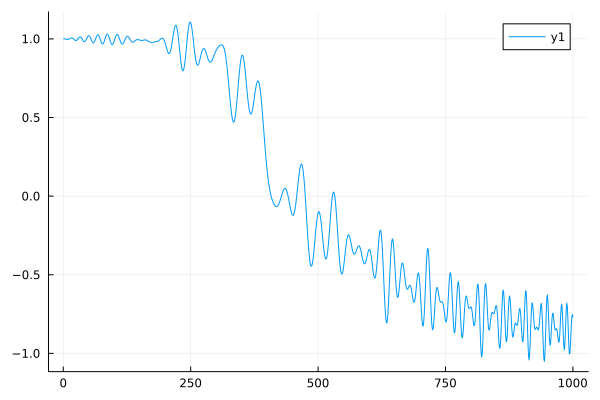

In [54]:
plot(energy)

In [11]:
# test the function for periodic boundary conditions
nq = 6
P= 10000
circuit, params = tfim_interpolation_circuit(nq, P; del_t=0.1, periodic=true)


H_tfim = PauliSum(nq)
topology = bricklayertopology(nq; periodic=true)
for qind in 1:nq
    add!(H_tfim, :X, qind, G)
end

for pair in topology
    add!(H_tfim, [:Z, :Z], collect(pair), J)
end


max_weight = 10
min_abs_coeff = 1e-7
propagated = propagate(circuit, H_tfim, params)#; max_weight, min_abs_coeff)
println(overlapwithplus(propagated)/nq)

-1.2790673350546895


ED for pbc TFIM:
- nq = 3: -1.15470054 -0.66666667 (gs and 1st excited state)
- nq = 4: -1.30656296 -1.20710678
- nq = 5: -1.23107341 -1.0472136 
- nq = 6: -1.2879011  -1.24401694

Observation: for even number of spins, by increasing P (and decreasing dt), we reach the ground state up to 10 qubits. 
But for odd number of spins, we always converge to the first excited state instead. This is because the TFIM preserves Z2 symmetry, and through the adiabatic evolution we are stuck in the same symmetry sector.

### Néel overlap (this works but only for odd spin number)

In [6]:
function overlapwithneel(operator, nq::Int; 
                           up_on_odd::Bool=true, 
                           params=nothing)
                           
    # Create Néel state bit representation: indices of "1" bits
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    
    # Compute overlap with computational basis state
    return overlapwithcomputational(operator, nb)
end

overlapwithneel (generic function with 1 method)

In [7]:
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        # |0101...> → "1" on even sites
        return collect(2:2:nq)
    else
        # |1010...> → "1" on odd sites
        return collect(1:2:nq)
    end
end

neel_bits (generic function with 1 method)

In [8]:
function heisenberg_interpolation_circuit(nq, P; del_t= 0.1, J=1.0, hbar=1.0, topology=nothing, periodic = false) 
    tau = del_t * P # tau is total annealing time, divided into P steps/layers of circuit
    if topology === nothing
        topology = bricklayertopology(nq; periodic=periodic)
    end
    circuit = heisenbergtrottercircuit(nq, P;topology=topology)
    periodic ? nbonds = nq : nbonds = nq - 1 # if periodic nq bonds, else nq-1 (1d chain)
    total = P * (3*nbonds)
    params  = Vector{Float64}(undef, total)
    idx = 1

    for m in 1:P # layers of trotterized circuit
        s_m = (m - 0.5) / P
        beta   = J * del_t / hbar    # ZZ coefficient
        gamma  =  J * s_m * del_t / hbar     # XX/YY coefficient
        θZZ = 2*beta
        θXX = 2*gamma
        θYY = 2*gamma
    
        @inbounds fill!(view(params, idx:idx+nbonds-1), θXX);             idx += nbonds
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), θYY);             idx += nbonds
        #println(params)
        @inbounds fill!(view(params, idx:idx+nbonds-1), θZZ);             idx += nbonds
        #println(params)
    end

    
    return circuit, params
end


heisenberg_interpolation_circuit (generic function with 1 method)

In [9]:
# test the function 
nq = 5
P= 10000
J=1.0 
circuit, params = heisenberg_interpolation_circuit(nq, P; del_t=0.1)
topology = bricklayertopology(nq; periodic=false)
H_heis = PauliSum(nq)
for (i,j) in topology
    add!(H_heis, [:X,:X], [i,j], J)
    add!(H_heis, [:Y,:Y], [i,j], J)
    add!(H_heis, [:Z,:Z], [i,j], J)
end
max_weight = 10
min_abs_coeff = 1e-7
propH = propagate(circuit, H_heis, params; max_weight, min_abs_coeff)

# Heisenberg-picture readout: ⟨+| U† H_heis U |+⟩
println("E_final = ", overlapwithneel(propH, nq)/nq)

E_final = -1.5307141637686306


Our results:(obc)
- nq=3: -1.327942
- nq=4: -1.27759
- nq=5: -1.53071
- nq=6: -1.4857734
- nq=7: -1.6064

### ED results Heisenberg: (obc)
- nq = 3: -1.33333333 -1.33333333 0 0 (gs, 1st excited, 2nd excited, ..)
- nq = 4: -1.6160254  -0.95710678
- nq = 5: -1.542309   -1.542309   -0.96568542 -0.96568542
- nq = 6: -1.66238476 -1.33466357 -1.33466357 -1.33466357
- nq = 7: -1.62070839 -1.62070839 -1.3022311  -1.3022311

This works for odd number of spins (but takes ages). For even nq we are stuck somewhere in between gs and 1st excited state.

## Breaking the SU(2) symmetry

### X drive to Heisenberg Hamiltonian
- Watch out: Heisenberg Hamiltonian commutes with the driver (X) that we used above --> i.e the Hamiltonian is conserved by the interpolating unitary
- If we want to keep the plus state as the departure state for the interpolating Hamiltonian, we need to break the SU(2) symmetry of the Heisenberg Hamiltonian
- One way to do this is to adjust the coeffs of the driver to all be positive but slightly different
- Another approach is taking the overlap with the Neelstate. This should lead to similar results as the TFIM. Since the ZZ driver and Hamiltonian partially commute, we should stay in the symmetry sector of the Néel state.

In [10]:
using PauliPropagation

# --- hyperparams ---
nq  = 3
topology = bricklayertopology(nq; periodic=false)
nbonds = nq - 1

del_t = 0.1
P= 100000
tau = del_t * P

hbar = 1.0
G = 1.0
J = 1.0
g = [1,1.6,0.4] # break SU(2) symmetry of Heisenberg model
# --- circuit: [X]*nq → [XX]*nbonds → [YY]*nbonds → [ZZ]*nbonds per layer ---
function dqa_heisenbergtrottercircuit(nqubits::Int, nlayers::Int; topology)
    circuit = Gate[]
    for _ in 1:nlayers
        for q in 1:nqubits
            push!(circuit, PauliRotation(:X, q))
        end
        rxxlayer!(circuit, topology)
        ryylayer!(circuit, topology)
        rzzlayer!(circuit, topology)
    end
    return circuit
end

circuit = dqa_heisenbergtrottercircuit(nq, P; topology)

# --- params packed as [X | XX | YY | ZZ] for each layer ---
total  = P*(nq + 3*nbonds)
params = Vector{Float64}(undef, total)
println("Total params = ", total)
idx = 1
for m in 1:P
    s_m = (m - 0.5) / P
    beta   = -g .*[(1- s_m) * del_t / hbar]     # X coefficient
    gamma  =  J * s_m       * del_t / hbar     # XX/YY/ZZ coefficient

    θX  = 2 .*beta
    θXX = 2*gamma
    θYY = 2*gamma
    θZZ = 2*gamma
    #println("done")
    #@inbounds fill!(view(params, idx:idx+nq-1), θX);                  idx += nq
    for i in 1:nq
        @inbounds fill!(view(params, idx-1+i), θX[i]) # to avoid broadcasting
    end
    #println(params)
    idx += nq
    @inbounds fill!(view(params, idx:idx+nbonds-1), θXX);             idx += nbonds
    #println(params)
    @inbounds fill!(view(params, idx:idx+nbonds-1), θYY);             idx += nbonds
    #println(params)
    @inbounds fill!(view(params, idx:idx+nbonds-1), θZZ);             idx += nbonds
    #println(params)
end

# --- final observable: Heisenberg only (no X term) ---
H_heis = PauliSum(nq)
for (i,j) in topology
    add!(H_heis, [:X,:X], [i,j], J)
    add!(H_heis, [:Y,:Y], [i,j], J)
    add!(H_heis, [:Z,:Z], [i,j], J)
end
max_weight = 5
min_abs_coeff = 1e-7
propH = propagate(circuit, H_heis, params; max_weight, min_abs_coeff)

# Heisenberg-picture readout: ⟨+| U† H_heis U |+⟩
println("E_final = ", overlapwithplus(propH)/nq)


Total params = 900000
E_final = -1.2754788653236941
